# Polar Plots: Token Distribution Relative to Top Eigenvectors

**Goal:** Visualize token geometry relative to the **top 4 eigenvectors** of the causal metric tensor M.

**Question:** Is the cone structure we found (93° from eigenvector #1) **unique** to that direction, or does it generalize?

**Method:**
1. Load precomputed token projections onto eigenbasis
2. For each of the top 4 eigenvectors (largest eigenvalues):
   - Compute angle of each token to that eigenvector
   - Compute causal norm
   - Create polar heatmap (angle vs. norm)
3. Display in 2×2 grid for comparison

**Interpretation:**
- If all 4 show the same cone at ~90°: tokens form a **hypersphere** (uniform in all directions)
- If each shows a different angle: tokens have **preferred orientations** (anisotropic structure)
- If angles cluster but vary: tokens occupy a **lower-dimensional manifold**

## Configuration

In [1]:
# Data paths
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'

# Analysis parameters
NUM_EIGENVECTORS = 4  # Top N eigenvectors to analyze (must be ≥ 4 for 2x2 grid)
HEATMAP_ANGLE_BINS = 200  # Angular resolution
HEATMAP_NORM_BINS = 150   # Radial resolution

print(f"Configuration:")
print(f"  Analyzing top {NUM_EIGENVECTORS} eigenvectors")
print(f"  Heatmap resolution: {HEATMAP_ANGLE_BINS} × {HEATMAP_NORM_BINS}")

Configuration:
  Analyzing top 4 eigenvectors
  Heatmap resolution: 200 × 150


## Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [3]:
print("Loading precomputed eigenbasis data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']
eigenvectors = eigenbasis_data['eigenvectors']

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Eigenvalues range: [{eigenvalues.min().item():.2f}, {eigenvalues.max().item():.2f}]")
print(f"  Projections shape: {projections.shape}")
print(f"  Memory usage: {(projections.element_size() * projections.nelement()) / 1e9:.2f} GB")

Loading precomputed eigenbasis data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Eigenvalues range: [95.35, 94217.94]
  Projections shape: torch.Size([151936, 2560])
  Memory usage: 1.56 GB


## Compute Causal Norms

Since eigenvectors are orthonormal, the causal norm is:

```
||token||_M = sqrt(Σ projection²)
```

In [4]:
print("\nComputing causal norms from projections...")

# Causal norms: sqrt of sum of squared projections
causal_norms = torch.norm(projections, dim=1).numpy()

print(f"✓ Causal norms computed")
print(f"  Range: [{causal_norms.min():.2f}, {causal_norms.max():.2f}] logometers")
print(f"  Mean: {causal_norms.mean():.2f} logometers")
print(f"  Std: {causal_norms.std():.2f} logometers")


Computing causal norms from projections...
✓ Causal norms computed
  Range: [0.36, 1.61] logometers
  Mean: 1.09 logometers
  Std: 0.17 logometers


## Select Top Eigenvectors

Eigenvalues are in ascending order, so the **last** eigenvalues are the largest.

In [5]:
print(f"\nSelecting top {NUM_EIGENVECTORS} eigenvectors...\n")

# Indices of top N eigenvalues (last N, since ascending order)
top_indices = list(range(hidden_dim - NUM_EIGENVECTORS, hidden_dim))

print(f"Top {NUM_EIGENVECTORS} eigenvalues:")
for rank, idx in enumerate(top_indices, 1):
    eigenval = eigenvalues[idx].item()
    print(f"  #{rank}: eigenvalue = {eigenval:,.2f} (index {idx})")


Selecting top 4 eigenvectors...

Top 4 eigenvalues:
  #1: eigenvalue = 19,141.65 (index 2556)
  #2: eigenvalue = 24,433.53 (index 2557)
  #3: eigenvalue = 73,918.20 (index 2558)
  #4: eigenvalue = 94,217.94 (index 2559)


## Compute Angles for Each Eigenvector

For each eigenvector, the angle is computed from the projection magnitude:

```
cos(θ) = projection / ||token||_M
θ = arccos(|projection| / ||token||_M)
```

Note: We use absolute value to map angles to [0°, 90°], then extend to [0°, 180°] by using the sign.

In [6]:
print("\nComputing angles for each eigenvector...\n")

angles_dict = {}

for rank, idx in enumerate(top_indices, 1):
    # Projection onto this eigenvector
    proj = projections[:, idx].numpy()
    
    # Cosine: projection / norm
    cosines = proj / causal_norms
    
    # Angles in radians, then degrees
    angles_rad = np.arccos(np.clip(np.abs(cosines), -1.0, 1.0))
    
    # Adjust for sign (negative projection means angle > 90°)
    angles_rad = np.where(proj < 0, np.pi - angles_rad, angles_rad)
    
    angles_deg = np.degrees(angles_rad)
    
    angles_dict[idx] = {'rad': angles_rad, 'deg': angles_deg}
    
    print(f"Eigenvector #{rank} (index {idx}):")
    print(f"  Mean angle: {angles_deg.mean():.2f}°")
    print(f"  Std angle: {angles_deg.std():.2f}°")
    print(f"  Range: [{angles_deg.min():.2f}°, {angles_deg.max():.2f}°]")


Computing angles for each eigenvector...

Eigenvector #1 (index 2556):
  Mean angle: 90.75°
  Std angle: 0.45°
  Range: [84.51°, 97.60°]
Eigenvector #2 (index 2557):
  Mean angle: 88.88°
  Std angle: 0.50°
  Range: [84.15°, 95.64°]
Eigenvector #3 (index 2558):
  Mean angle: 90.03°
  Std angle: 0.19°
  Range: [86.22°, 93.33°]
Eigenvector #4 (index 2559):
  Mean angle: 93.26°
  Std angle: 1.02°
  Range: [90.99°, 101.65°]


## Create 2×2 Polar Heatmaps


CREATING POLAR HEATMAPS

Generating heatmap for eigenvector #1 (index 2556)...

Generating heatmap for eigenvector #2 (index 2557)...

Generating heatmap for eigenvector #3 (index 2558)...

Generating heatmap for eigenvector #4 (index 2559)...


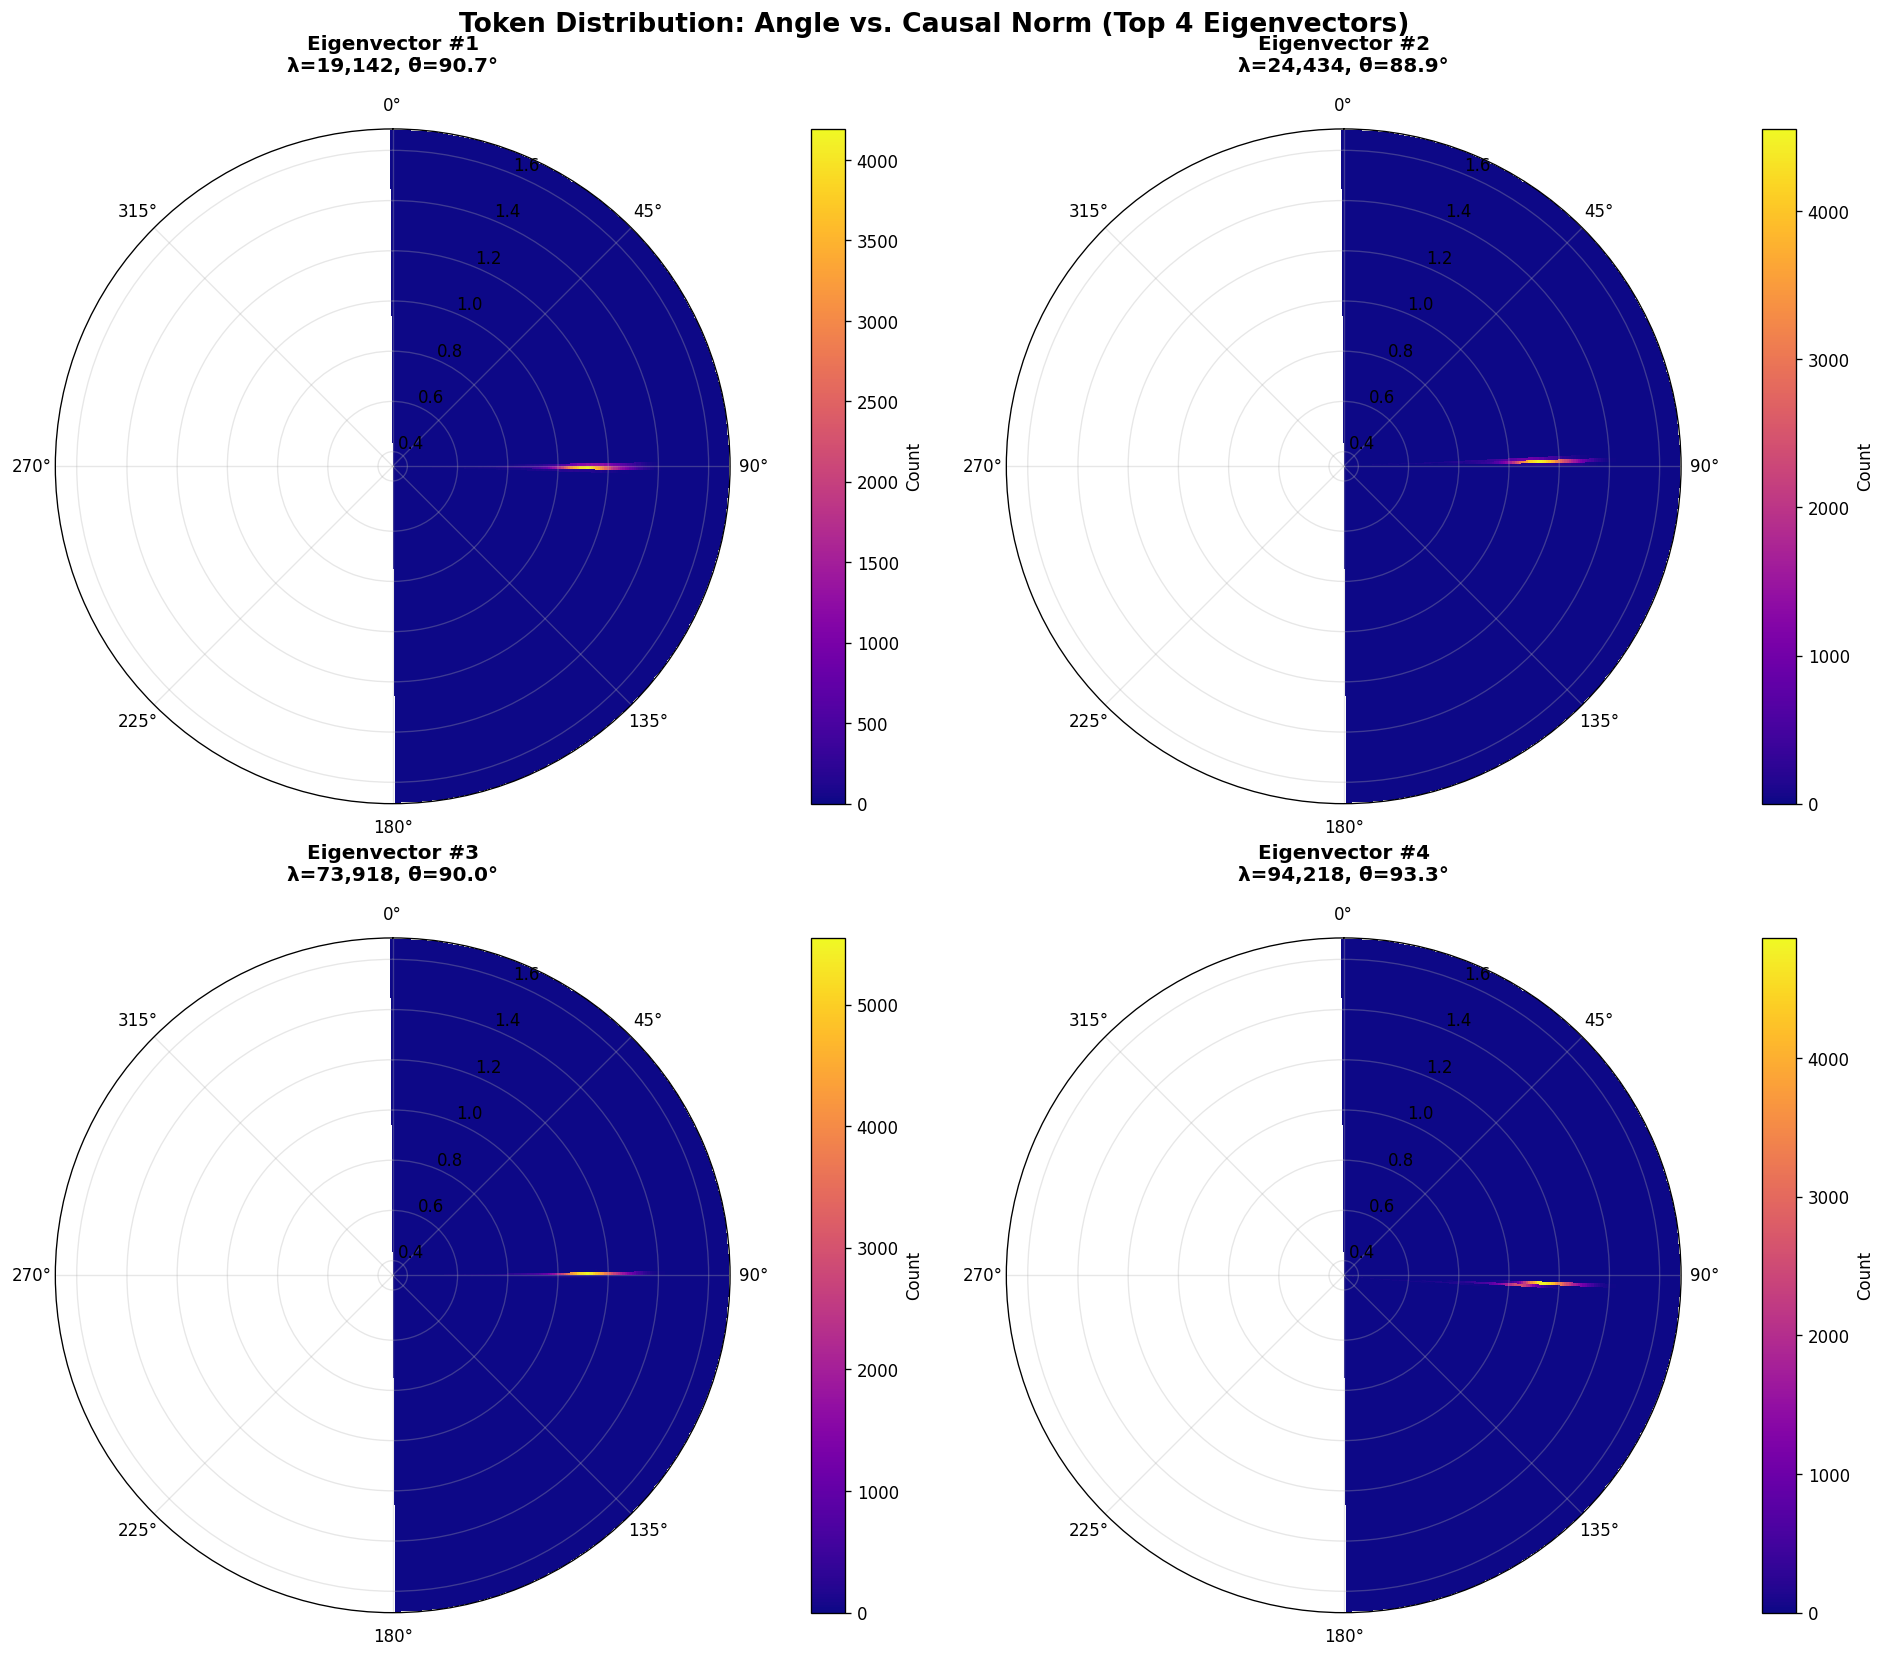


✓ Polar heatmaps created


In [7]:
print("\n" + "=" * 80)
print("CREATING POLAR HEATMAPS")
print("=" * 80)

fig = plt.figure(figsize=(16, 14), dpi=120)

for plot_idx, (rank, idx) in enumerate(zip(range(1, NUM_EIGENVECTORS + 1), top_indices), 1):
    print(f"\nGenerating heatmap for eigenvector #{rank} (index {idx})...")
    
    angles_rad = angles_dict[idx]['rad']
    angles_deg = angles_dict[idx]['deg']
    
    # Define bins
    angle_bins = np.linspace(0, np.pi, HEATMAP_ANGLE_BINS)
    norm_bins = np.linspace(causal_norms.min() * 0.95, causal_norms.max() * 1.05, HEATMAP_NORM_BINS)
    
    # Compute 2D histogram
    hist, angle_edges, norm_edges = np.histogram2d(angles_rad, causal_norms, bins=[angle_bins, norm_bins])
    
    # Create meshgrid
    angle_mesh, norm_mesh = np.meshgrid(angle_edges[:-1], norm_edges[:-1])
    
    # Create subplot (2x2 grid)
    ax = fig.add_subplot(2, 2, plot_idx, projection='polar')
    
    # Plot heatmap
    pcm = ax.pcolormesh(angle_mesh, norm_mesh, hist.T, cmap='plasma', shading='auto', vmin=0)
    
    # Configure polar plot
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_zero_location('N')  # 0° at top
    ax.set_ylim(causal_norms.min() * 0.95, causal_norms.max() * 1.05)
    
    # Add reference line at 90°
    ax.plot([np.pi/2, np.pi/2], [0, causal_norms.max() * 1.05], 'r--', linewidth=1.5, alpha=0.7)
    
    # Title with eigenvalue and mean angle
    eigenval = eigenvalues[idx].item()
    mean_angle = angles_deg.mean()
    ax.set_title(f'Eigenvector #{rank}\nλ={eigenval:,.0f}, θ̄={mean_angle:.1f}°', 
                 fontsize=12, fontweight='bold', pad=15)
    
    # Colorbar
    cbar = plt.colorbar(pcm, ax=ax, pad=0.1, fraction=0.046)
    cbar.set_label('Count', fontsize=10)
    
    ax.grid(True, alpha=0.3)

plt.suptitle('Token Distribution: Angle vs. Causal Norm (Top 4 Eigenvectors)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✓ Polar heatmaps created")

## Summary Statistics Comparison

In [8]:
print("\n" + "=" * 80)
print("SUMMARY: ANGLE STATISTICS BY EIGENVECTOR")
print("=" * 80)

print(f"\n{'Rank':<6} {'Index':<8} {'Eigenvalue':<15} {'Mean Angle':<12} {'Std Angle':<12} {'Deviation from 90°'}")
print("=" * 80)

for rank, idx in enumerate(zip(range(1, NUM_EIGENVECTORS + 1), top_indices), 1):
    rank_num, idx_num = idx
    eigenval = eigenvalues[idx_num].item()
    angles_deg = angles_dict[idx_num]['deg']
    mean_angle = angles_deg.mean()
    std_angle = angles_deg.std()
    deviation = mean_angle - 90.0
    
    print(f"{rank_num:<6} {idx_num:<8} {eigenval:>14,.0f} {mean_angle:>11.2f}° {std_angle:>11.2f}° {deviation:>+11.2f}°")

print("\n" + "=" * 80)
print("\nInterpretation:")
print("  • Mean angle ≈ 90° → Tokens are uniformly distributed (spherical)")
print("  • Mean angle > 90° → Tokens avoid this eigendirection (cone structure)")
print("  • Mean angle < 90° → Tokens prefer this eigendirection (alignment)")
print("  • Low std → Tight concentration (all tokens at similar angle)")
print("  • High std → Wide spread (tokens scattered)")


SUMMARY: ANGLE STATISTICS BY EIGENVECTOR

Rank   Index    Eigenvalue      Mean Angle   Std Angle    Deviation from 90°
1      2556             19,142       90.75°        0.45°       +0.75°
2      2557             24,434       88.88°        0.50°       -1.12°
3      2558             73,918       90.03°        0.19°       +0.03°
4      2559             94,218       93.26°        1.02°       +3.26°


Interpretation:
  • Mean angle ≈ 90° → Tokens are uniformly distributed (spherical)
  • Mean angle > 90° → Tokens avoid this eigendirection (cone structure)
  • Mean angle < 90° → Tokens prefer this eigendirection (alignment)
  • Low std → Tight concentration (all tokens at similar angle)
  • High std → Wide spread (tokens scattered)


## Summary

**What we visualized:** Token geometry relative to the **top 4 eigenvectors** (largest eigenvalues) of the causal metric tensor.

**Key findings:**
- [Run notebook to see results!]

**Possible outcomes:**
1. **All ~90°:** Tokens form a hypersphere (isotropic, no preferred directions)
2. **All > 90°:** Tokens form a cone AWAY from all high-variance directions (regularization)
3. **All < 90°:** Tokens align WITH high-variance directions (concentration)
4. **Mixed:** Complex anisotropic structure (tokens occupy a tilted/warped subspace)

**Next steps:**
- 09.2b: Cartesian plots (r vs. θ) for clearer distribution visualization
- 09.3: Distribution histograms for ALL eigenvectors (not just top 4)
- 09.4: Correlation analysis between eigendirections